<a href="https://colab.research.google.com/github/pullz6/Airline_Study/blob/main/Airline_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all libraires and the dataset.

In [19]:
import pandas as pds
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics


drive.mount('/content/drive')

file = ('/content/drive/MyDrive/sample_data/Thesis/capstone_airline_reviews3.xlsx')
file_1 = ('/content/drive/MyDrive/sample_data/Thesis/reviews_data.csv')
file_2 = ('/content/drive/MyDrive/sample_data/Thesis/rating_data.csv')
airline = pds.read_excel(file)
airline = airline.dropna()
airline = airline.reset_index(drop=True)
ba_reviews = pds.read_csv(file_1)
ba_ratings = pds.read_csv(file_2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Passenger Segmentation

In [20]:
airline.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
1,Turkish Airlines,2.0,S Gonser,29th April 2019,âœ… Trip Verified | Basel to Cape Town via Ist...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,April 2019,3.0,3.0,2.0,3.0,1.0,2.0,no
2,Turkish Airlines,6.0,Sami Osman,29th April 2019,Not Verified | Abu Dhabi to Luxembourg via Ist...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,April 2019,2.0,3.0,3.0,3.0,3.0,3.0,yes
3,Turkish Airlines,1.0,Norka Idalia Orlando,28th April 2019,âœ… Trip Verified | The experience with Turkis...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,February 2019,1.0,1.0,1.0,1.0,1.0,1.0,no
4,Turkish Airlines,2.0,Trevor Khurana,24th April 2019,âœ… Trip Verified | Houston to Kiev via Istanb...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,March 2019,1.0,3.0,2.0,2.0,1.0,1.0,no


Cleaning the customer reviews in the dataset from unwanted information or characaters.

In [21]:
airline.drop('author',axis=1,inplace=True)
airline['Verified'] = np.where(airline['customer_review'].str.contains('Trip Verified'), True, False)
airline.drop('review_date',axis=1,inplace=True)
airline["customer_review"] = airline["customer_review"].str.replace("âœ… Trip Verified |","")
airline["customer_review"] = airline["customer_review"].str.replace("Not Verified |","")
airline["customer_review"] = airline["customer_review"].str.replace("âœ… Verified","")
airline["customer_review"] = airline["customer_review"].str.replace("|","")
airline['date_flown']=pd.to_datetime(airline['date_flown'].astype(str))
airline.head()

<ipython-input-21-f1aeddabbeb3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  airline["customer_review"] = airline["customer_review"].str.replace("âœ… Trip Verified |","")
<ipython-input-21-f1aeddabbeb3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  airline["customer_review"] = airline["customer_review"].str.replace("Not Verified |","")
<ipython-input-21-f1aeddabbeb3>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  airline["customer_review"] = airline["customer_review"].str.replace("|","")


,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended,Verified
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,5.0,5.0,5.0,5.0,yes,True
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,2.0,3.0,1.0,2.0,no,True
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,3.0,3.0,3.0,3.0,yes,False
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,1.0,1.0,1.0,1.0,no,True
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,2.0,2.0,1.0,1.0,no,True


In [22]:
airline['cabin'].unique()

array(['Economy Class', 'Business Class', 'First Class',
       'Premium Economy'], dtype=object)

Adding an attribute for customers who are transiting.

In [23]:
airline_1 = pd.DataFrame(airline.route.str.split(' to ',1).tolist(),columns = ['fips','row'])
airline['Start'] = airline_1['fips']
airline['row'] = airline_1['row']
airline['Transit'] = airline['row'].str.contains('via')
airline['Destination'] = airline['row'].str.split(' ').str[-1]
airline.drop('row',inplace=True,axis=1)

<ipython-input-23-b40abb6a79d9>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  airline_1 = pd.DataFrame(airline.route.str.split(' to ',1).tolist(),columns = ['fips','row'])


Creating an attribute for the type of aircraft that a passenger is flying in.

In [24]:
conditions = [
    airline["aircraft"].str.contains('Boeing') & airline["aircraft"].str.contains('A')  == True,
    airline["aircraft"].str.contains('|'.join(['Boeing', 'boeing','B','Dreamliner','dreamliner'])) == True,
    airline["aircraft"].str.contains('A') == True
]
choices = ['Both','Boeing','Airbus']
airline['aircraft_manu'] = np.select(conditions, choices)

In [25]:
airline['aircraft_manu'] = np.where(airline['aircraft_manu']=='0', 'Other', airline['aircraft_manu'])

In [26]:
airline['aircraft_manu'].unique()

array(['Airbus', 'Both', 'Boeing', 'Other'], dtype=object)

Creating an attribute for the season that the passenger flew in.

In [27]:
airline['month'] = airline.date_flown.dt.month

def find_season(month):
        season_month = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month.get(month)

season_list = []
for month in airline['month']:
    season = find_season(month)
    season_list.append(season)

airline['Season'] = season_list

In [28]:
airports = pd.read_csv('/content/drive/MyDrive/sample_data/Thesis/GlobalAirportDatabase.txt', sep=":", header=None)
airports.columns = ["ICAO Code", "IATA Code", "Airport Name", "City/Town",'Country','Latitude Degrees','Latitude Minutes','Latitude Seconds','Latitude Direction','Longitude Degrees','Longitude Minutes','Longitude Seconds','Longitude Direction','Altitude','Latitude Decimal Degrees','Longitude Decimal Degrees']

In [24]:
airports.head()

,ICAO Code,IATA Code,Airport Name,City/Town,Country,Latitude Degrees,Latitude Minutes,Latitude Seconds,Latitude Direction,Longitude Degrees,Longitude Minutes,Longitude Seconds,Longitude Direction,Altitude,Latitude Decimal Degrees,Longitude Decimal Degrees
0,AYGA,GKA,Goroka,Goroka,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,,Lae,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,Madang,Madang,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,Mount Hagen,Mount Hagen,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,Nadzab,Nadzab,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726


AttributeError: ignored

In [31]:
airports['City/Town'] = airports['City/Town'].str.title()
airports['Airport Name'] = airports['Airport Name'].str.title()
airports['Country'] = airports['Country'].str.title()
airports = airports.replace(np.nan, '', regex=True)

In [32]:
airports['City/Town'].unique()

array(['Goroka', 'Lae', 'Madang', ..., 'Xiancheng', 'Yichun', 'Yanji'],
      dtype=object)

In [33]:
import operator as op
x = 0
check = 0
not_count = 0
no_x = []
country_holder = []
for i in airline.itertuples():
  check = 0
  for j in airports.itertuples():
    city = str(j[4])
    airport = str(j[3])
    iata = str(j[2])
    icao = str(j[1])
    if (op.contains(i[-6],city)):
      country_holder.append(j[5])
      check = 1
      x = x + 1
      break
    elif (op.contains(i[-6],airport)):
      country_holder.append(j[5])
      check = 1
      x = x + 1
      break
    elif (op.contains(i[-6],iata)):
      country_holder.append(j[5])
      check = 1
      x = x + 1
      break
    elif (op.contains(i[-6],icao)):
      country_holder.append(j[5])
      check = 1
      x = x + 1
      break
  if check ==0 :
    country_holder.append("None")
    not_count = not_count+1
    no_x.append(i[-6])
print('in')
print(x)
print('not in')
print(not_count)
print(no_x)

in
14212
not in
0
[]


In [34]:
print(country_holder)

['Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea', 'Papua New Guinea',

In [16]:
airline['start_country'] = country_holder

In [17]:
airline['start_country'].unique()

array(['PAPUA NEW GUINEA'], dtype=object)

In [18]:
x = 0
not_count = 0
no_x = []
airport_city = airports['City/Town'].values.tolist()
airport_iata = airports['IATA Code'].values.tolist()
airport_name = airports['Airport Name'].values.tolist()
count = 0
country_holder = []
for i in airline.itertuples():
  if i[-6] in airports['City/Town'].values:
    x = x + 1
  elif i[-6] in airports['IATA Code'].values:
    x = x + 1
  elif i[-6] in airports['Airport Name'].values:
    x = x + 1
  elif i[-6] in airports['ICAO Code'].values:
    x = x + 1
  else:
    no_x.append(i[-6])
    not_count = not_count + 1
  count = count +1
print('in')
print(x)
print('not in')
print(not_count)
print(no_x)

in
0
not in
14212
[False, True, True, True, True, False, False, False, True, False, False, False, True, False, True, True, True, False, False, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, True, True, False, True, True, False, False, False, False, False, True, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, False, True, True, True, False, False, True, False, True, False, False, True, False, True, True, True, False, False, True, False, False, False, False, False, False, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, False, False, False, False, False, False, True, False, Tr

Creating an attribute on where the passenger got on

In [ ]:
airline['Start'].unique()

array(['Washington Dulles', 'Basel', 'Abu Dhabi', ..., 'Astana',
       'Bergamo', 'Yerevan'], dtype=object)

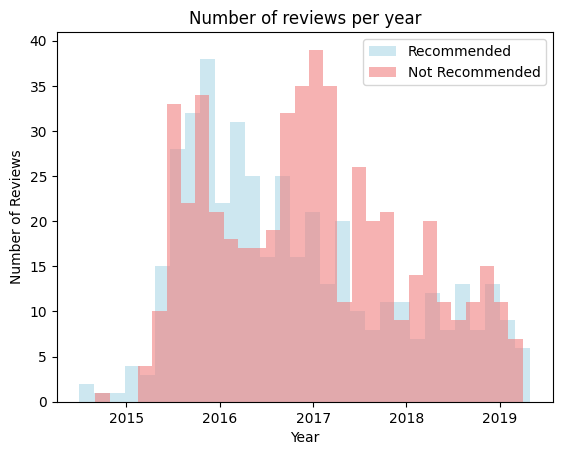

In [ ]:
#to group it per year, take hte mean value per year for Brisith Airways.
plt.figure()
bae = airline[airline['airline'].str.contains('British Airways')]
plt.hist(bae['date_flown'][bae['recommended']=='yes'],bins=30,color = "lightblue",label='Recommended',alpha=0.6)
plt.hist(bae['date_flown'][bae['recommended']=='no'],bins=30,color = "lightcoral",label='Not Recommended',alpha=0.6)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of reviews per year')
plt.show()

Initial analsyis on the top airlines.

<ipython-input-14-c3e03af118df>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_by_airline = airline.groupby('airline')['overall', 'seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money'].mean()


<Figure size 640x480 with 0 Axes>

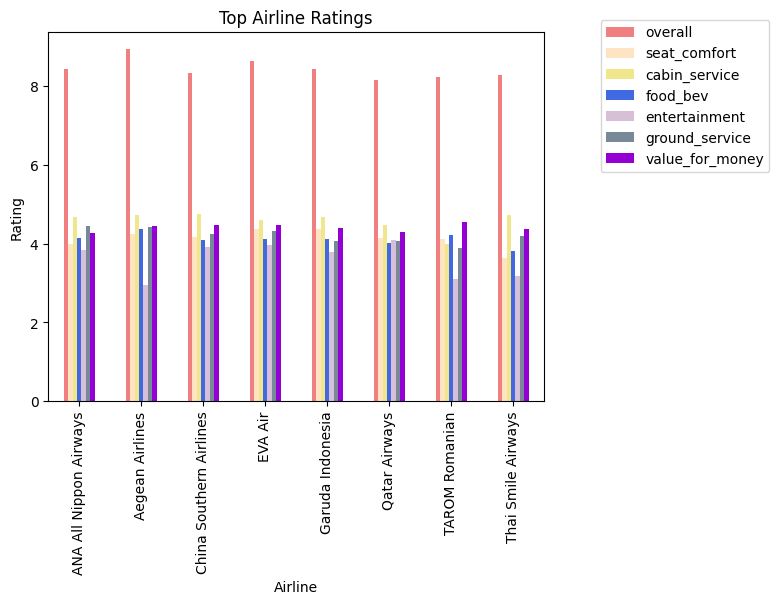

In [ ]:
grouped_by_airline = airline.groupby('airline')['overall', 'seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money'].mean()
grouped_by_airline = grouped_by_airline[grouped_by_airline['overall'] > 8]
plt.figure()
grouped_by_airline.plot.bar(color={"overall": "lightcoral", "seat_comfort": "bisque","cabin_service": "khaki","food_bev": "royalblue","entertainment": "thistle","ground_service": "lightslategrey","value_for_money": "darkviolet"})
plt.xlabel('Airline')
plt.ylabel('Rating')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Top Airline Ratings')
plt.show()

Quadrant Analysis for popular airlines such as Qatar Airways, Emirates, Lufthansa, KLM Royal Dutch Airlines,American Airlines,Air France,Etihad Airways and British Airways

In [ ]:
airline['airline'].unique()
#filtering the selected airlines
selected_airlines = airline[airline['airline'].isin(['Qatar Airways', 'Emirates', 'Lufthansa', 'KLM Royal Dutch Airlines','American Airlines','Air France','Etihad Airways','British Airways'])]
#resetting the index of the dataset
selected_airlines.reset_index(drop = True, inplace=True)
#dropping features we are not interested in.
selected_airlines = selected_airlines.drop(['customer_review','aircraft','traveller_type','cabin','route','date_flown','seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money','Verified','Start','Destination','aircraft_manu','Transit','Season','month'], axis=1)

In [ ]:
selected_airlines

,airline,overall,recommended
0,Qatar Airways,6.0,yes
1,Qatar Airways,9.0,yes
2,Qatar Airways,9.0,yes
3,Qatar Airways,10.0,yes
4,Qatar Airways,4.0,yes
...,...,...,...
4358,Etihad Airways,1.0,no
4359,Etihad Airways,7.0,yes
4360,Etihad Airways,3.0,no
4361,Etihad Airways,1.0,no


In [ ]:
#removing datapoints that has no in recommendations
index_names = selected_airlines[selected_airlines['recommended'].isin(['no'])].index
#resetting the index
selected_airlines.drop(index_names,inplace=True)

In [ ]:
#creating a dataframe with just the mean value of the overal rating for each airline and counting the number of recommendations.
selected_airlines = selected_airlines.groupby('airline').agg({'overall':'mean','recommended':'count'})
#getting the average mean
mean_overall = selected_airlines['overall'].mean()
#getting the mean of all the recommendations
mean_recomm = selected_airlines['recommended'].mean()

Text(0.5, 1.0, 'Quadrant Analysis on Popular Airlines')

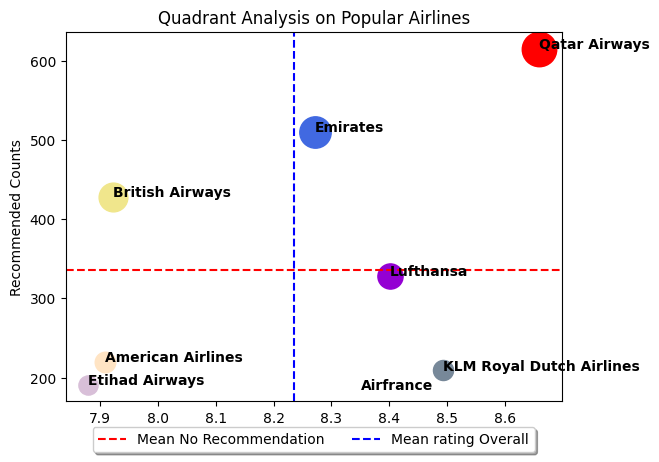

In [ ]:
#colors for each alirline
color = ['lightcoral','bisque','khaki','royalblue','thistle','lightslategrey','darkviolet','red']
#labels or the. names of each airline
labels = ['Airfrance','American Airlines','British Airways','Emirates','Etihad Airways','KLM Royal Dutch Airlines','Lufthansa','Qatar Airways']
#starting the plotting with a figure
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_cor=[]
y_cor=[]
z = 0
#loop the labels, find the matching airline in that label and plot that point
for i in labels:
  group = selected_airlines[selected_airlines.index.str.contains(i)]
  group.plot.scatter(x='overall', y='recommended', c=color[z], s = 'recommended', ax=ax1)
  value_1= group['overall'].to_numpy()
  value_2 = group['recommended'].to_numpy()
  #save the point coordinates
  x_cor.append(value_1.astype(int))
  y_cor.append(value_2.astype(int))
  z= z+1
x_cor = selected_airlines['overall'].squeeze()
y_cor= selected_airlines['recommended'].squeeze()
#plot the labels
for i, txt in enumerate(labels):
    ax1.annotate(txt, (x_cor[i], y_cor[i]), weight='bold')
#detailing the plot
plt.ylabel('Recommended Counts')
plt.xlabel('Mean Rating')
plt.axhline(y=mean_recomm, color="red", linestyle="--",label='Mean No Recommendation')
plt.axvline(x=mean_overall, color="blue", linestyle="--",label = 'Mean rating Overall')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Quadrant Analysis on Popular Airlines", fontsize=12)

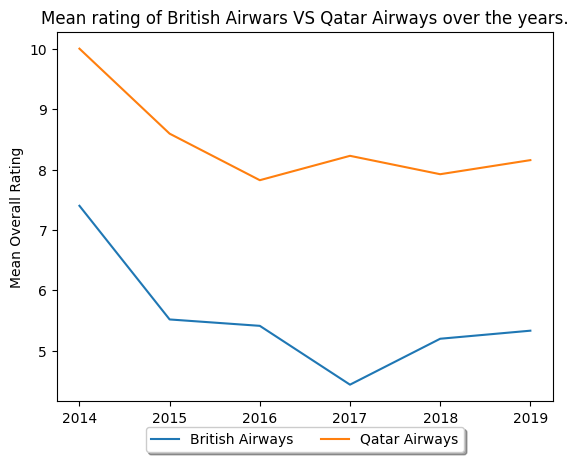

In [ ]:
bae_data = airline[airline['airline'].str.contains('British Airways')]
bae_data = bae_data.groupby(bae_data.date_flown.dt.year)['overall'].mean()
bae_data = bae_data.to_frame()
qatar_data = airline[airline['airline'].str.contains('Qatar Airways')]
qatar_data = qatar_data.groupby(qatar_data.date_flown.dt.year)['overall'].mean()
qatar_data = qatar_data.to_frame()

plt.figure()
plt.plot(bae_data.index,bae_data['overall'],label='British Airways')
plt.plot(qatar_data.index,qatar_data['overall'],label='Qatar Airways')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel('Year')
plt.ylabel('Mean Overall Rating')
plt.title('Mean rating of British Airwars VS Qatar Airways over the years.')
plt.show()

Preparing a dataset copy for K-means clustering analysis.

In [ ]:
x_knn_copy = airline.copy()
x_knn_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','seat_comfort','cabin_service','food_bev','entertainment','ground_service','recommended','Verified','month','overall','value_for_money'], axis=1, inplace=True)
#x_knn_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','Destination','recommended','Verified'], axis=1, inplace=True)

Converting categorical data into numerical data.

In [ ]:
#Since there is not much difference between the numerical ratings between the data points there is no need to include a minmaxscaling method.

le = LabelEncoder()
y = x_knn_copy['traveller_type']
z= x_knn_copy['cabin']
x_knn_copy['traveller_type'] = le.fit_transform(x_knn_copy['traveller_type'])
y = le.transform(y)
x_knn_copy['cabin'] = le.fit_transform(x_knn_copy['cabin'])
z = le.transform(z)
p = x_knn_copy['Season']
x_knn_copy['Season'] = le.fit_transform(x_knn_copy['Season'])
p = le.transform(p)
r = x_knn_copy['Destination']
x_knn_copy['Destination'] = le.fit_transform(x_knn_copy['Destination'])
r = le.transform(r)
x_knn_copy['Transit']=le.fit_transform(x_knn_copy['Transit'])
x_knn_copy['aircraft_manu']=le.fit_transform(x_knn_copy['aircraft_manu'])
x_knn_copy.head()

,traveller_type,cabin,Transit,Destination,aircraft_manu,Season
0,3,1,0,439,0,1
1,3,1,1,397,2,1
2,3,1,1,397,2,1
3,3,1,1,397,0,3
4,3,1,1,397,1,1


Conduting the k-means clustering method to better understand how many clusters should we select for the clustering.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
clusters = []
ss = []

#Calculate all the sum of within-cluster variance for n_clusters from 2 to 14

for i in range(2,15):
    gmm = GaussianMixture(n_components = i)
    labels = gmm.fit(x_knn_copy)
    labels = gmm.predict(x_knn_copy)
    clusters.append(labels[0])
    ss.append(silhouette_score(x_knn_copy, labels, metric='euclidean'))

KeyboardInterrupt: ignored

In [ ]:
ss

[0.48260294951956434,
 0.2732401490727076,
 0.1888770409106937,
 0.12713128882307356,
 0.10328459273266873,
 0.08048654116974162,
 0.08632614298295407,
 0.08349546904917364,
 0.08010132281814386,
 0.07797249452455576,
 0.03986865406942238,
 0.06276588433842033,
 0.06334562553457934]

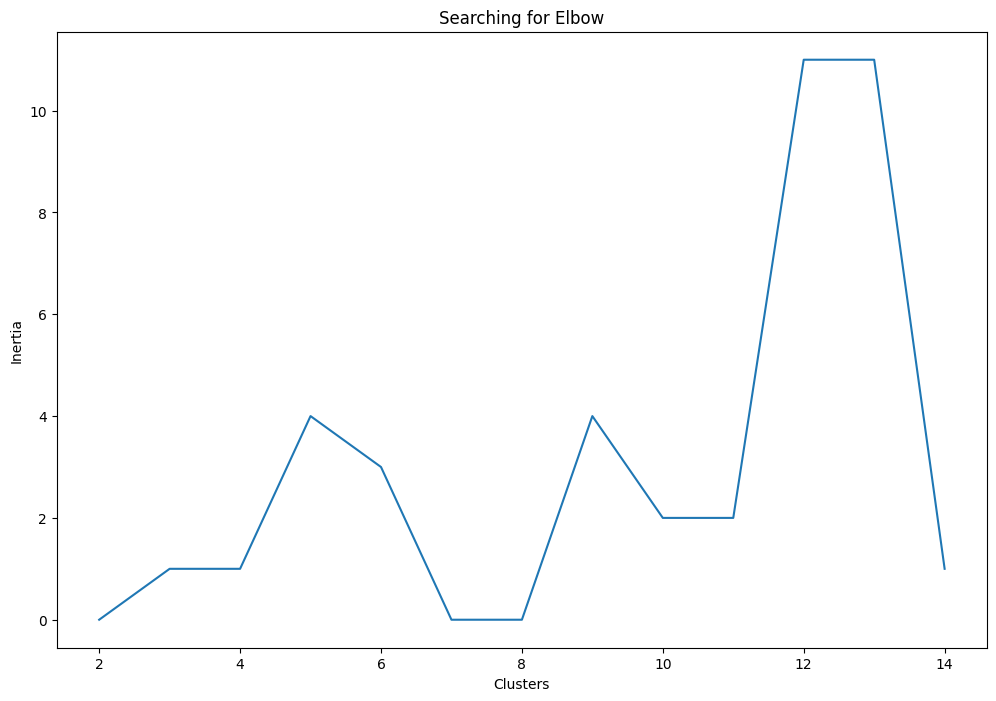

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(2, 15)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(6, 57000), xytext=(3, 50000), xycoords='data',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

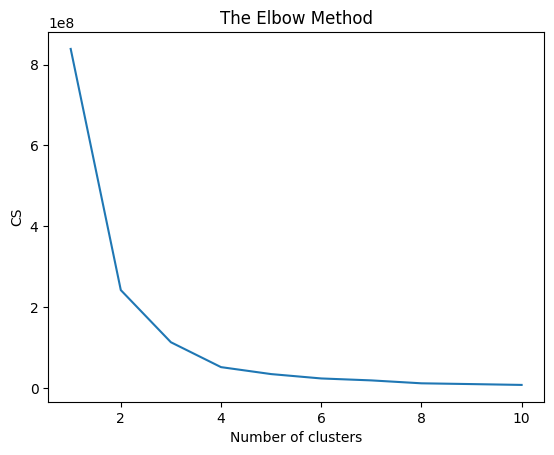

In [ ]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 4362, n_init = "auto", random_state = 0)
    kmeans.fit(x_knn_copy)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

We can see that 2 clusters seems ideal for our k-means clustering.

In [ ]:
x_knn_copy

,traveller_type,cabin,Transit,Destination,aircraft_manu,Season
0,3,1,0,439,0,1
1,3,1,1,397,2,1
2,3,1,1,397,2,1
3,3,1,1,397,0,3
4,3,1,1,397,1,1
...,...,...,...,...,...,...
14207,3,1,1,419,1,0
14208,1,1,1,419,1,3
14209,2,1,0,509,1,2
14210,1,1,0,684,1,2


In [ ]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(x_knn_copy)
labels = kmeans.labels_
labels = kmeans.predict(x_knn_copy)
s = metrics.silhouette_score(x_knn_copy, labels, metric='euclidean')
print(f'Silhouette Coefficient for the Iris Dataset Clusters: {s:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Coefficient for the Iris Dataset Clusters: 0.61


In [ ]:
cent = kmeans.cluster_centers_
kmeans = pd.DataFrame(labels)
airline.insert((x_knn_copy.shape[1]),'kmeans',kmeans)
x_knn_copy.insert((x_knn_copy.shape[1]),'kmeans',kmeans)
x_knn_copy.head()

NameError: ignored

k-means on british airways.

In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,kmeans,route,date_flown,seat_comfort,...,ground_service,value_for_money,recommended,Verified,Start,Transit,Destination,aircraft_manu,month,Season
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,0,Washington Dulles to Karachi,2019-04-01,4.0,...,5.0,5.0,yes,True,Washington Dulles,False,Karachi,Airbus,4,Spring
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,3,Basel to Cape Town via Istanbul,2019-04-01,3.0,...,1.0,2.0,no,True,Basel,True,Istanbul,Both,4,Spring
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,3,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,...,3.0,3.0,yes,False,Abu Dhabi,True,Istanbul,Both,4,Spring
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,3,Venice to Boston via Istanbul,2019-02-01,1.0,...,1.0,1.0,no,True,Venice,True,Istanbul,Airbus,2,Winter
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,3,Houston to Kiev via Istanbul,2019-03-01,1.0,...,1.0,1.0,no,True,Houston,True,Istanbul,Boeing,3,Spring


<Axes: xlabel='kmeans'>

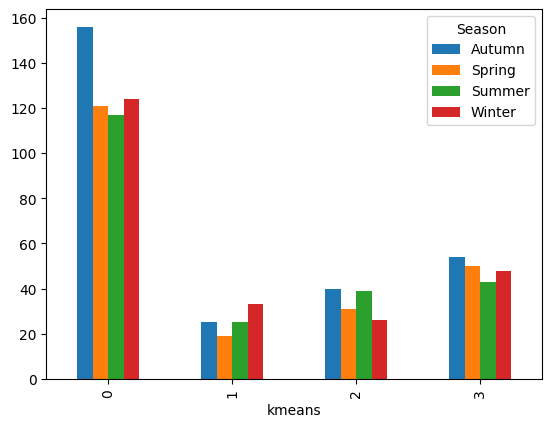

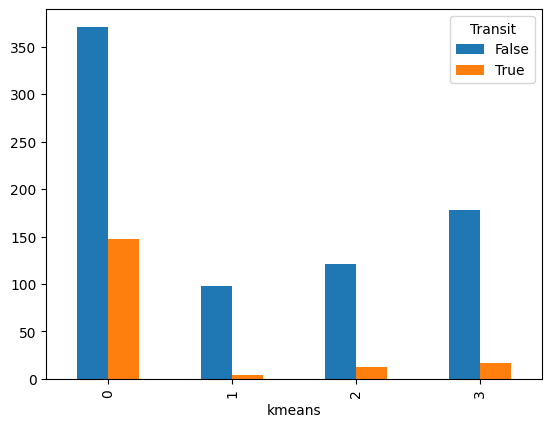

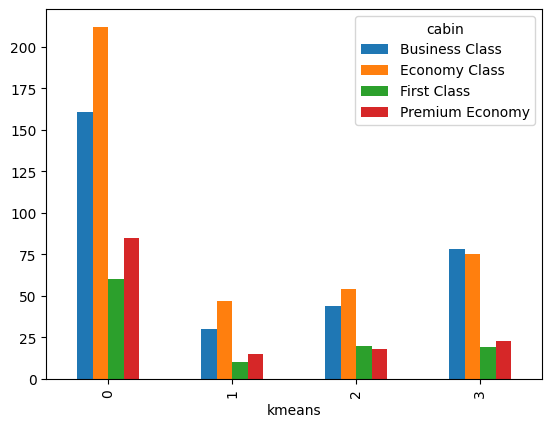

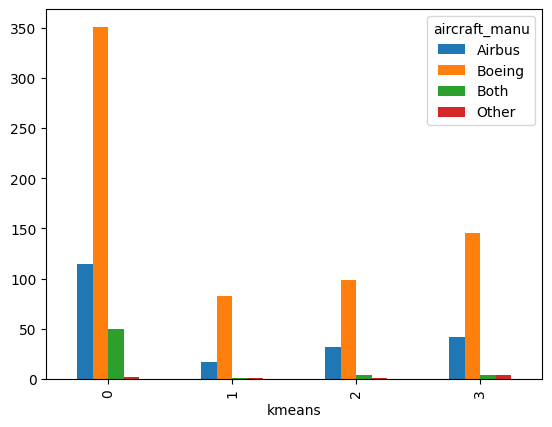

In [ ]:
bae_data = airline[airline['airline'].str.contains('British Airways')]
bae_data_1 = bae_data[bae_data['kmeans']==1]
bae_data_2 = bae_data[bae_data['kmeans']==0]

bae_data.groupby('kmeans').Season.value_counts().unstack().plot.bar()
bae_data.groupby('kmeans').Transit.value_counts().unstack().plot.bar()
bae_data.groupby('kmeans').cabin.value_counts().unstack().plot.bar()
bae_data.groupby('kmeans').aircraft_manu.value_counts().unstack().plot.bar()


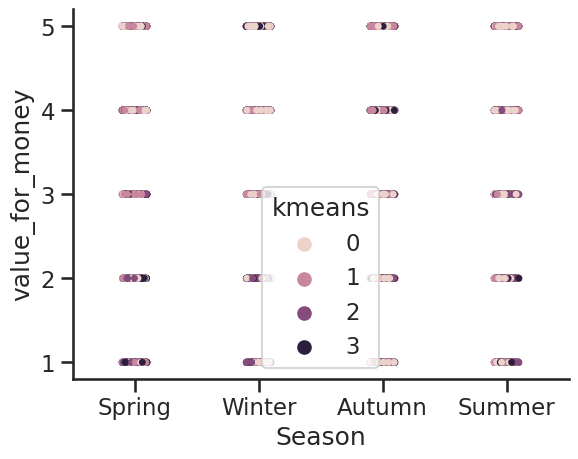

In [ ]:
import seaborn as sns
sns.stripplot(data=airline, x="Season", y = 'value_for_money',hue = 'kmeans', jitter=True)
sns.despine()

TypeError: ignored

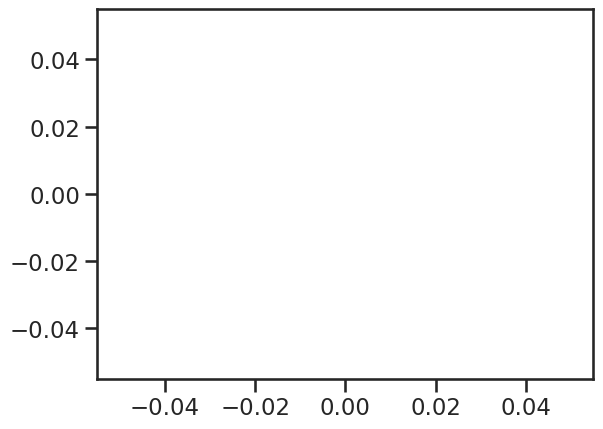

In [ ]:
sns.regplot(data = airline, x = 'Season', y = 'value_for_money', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})

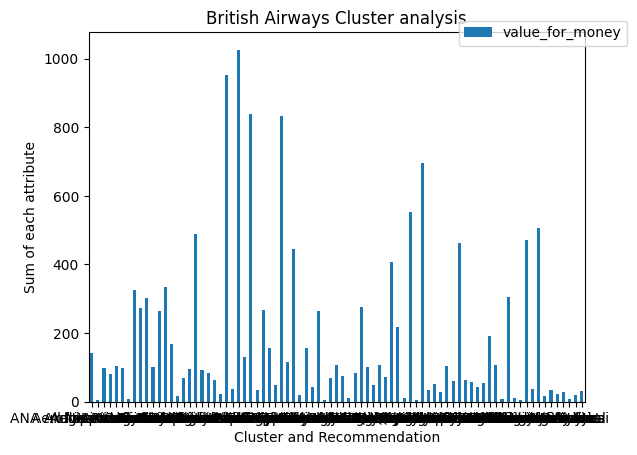

In [ ]:
sum_airlines = airline.groupby(['airline']).count()
sum_airlines = sum_airlines['value_for_money']
plt.figure()
sum_airlines.plot.bar()
plt.xlabel('Cluster and Recommendation')
plt.ylabel('Sum of each attribute')
plt.xticks(rotation ='horizontal')
plt.title('British Airways Cluster analysis')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

<ipython-input-27-375f0594957c>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  british_a_bar = british_a_bar.groupby(['kmeans','recommended']).mean()


<Figure size 640x480 with 0 Axes>

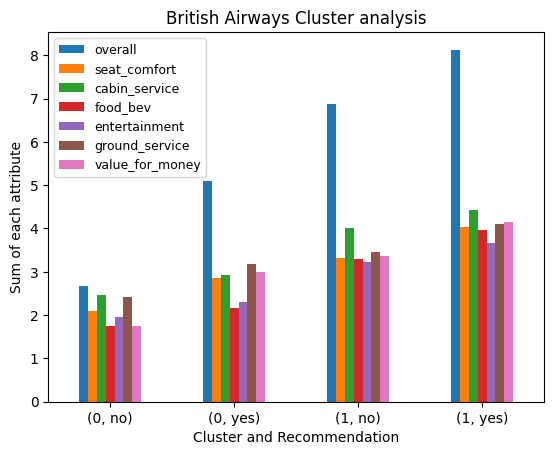

In [ ]:
british_airways = airline[airline['airline'].str.contains('British')]
british_a_bar = british_airways.copy()
british_a_bar.drop('Verified',axis=1, inplace=True)
british_airways_cluster_1 = british_a_bar[british_a_bar['kmeans']==0]
british_airways_cluster_2 = british_a_bar[british_a_bar['kmeans']==1]
british_airways_cluster_1

plt.figure()
british_a_bar = british_a_bar.groupby(['kmeans','recommended']).mean()
british_a_bar.plot.bar()
plt.xlabel('Cluster and Recommendation')
plt.ylabel('Sum of each attribute')
plt.xticks(rotation ='horizontal')
plt.title('British Airways Cluster analysis')
plt.legend(fontsize="9",loc='upper left')
plt.show()


# Density Based Clustering


```
# This is formatted as code
```



In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,entertainment,ground_service,kmeans,value_for_money,recommended,Verified,Start,Transit,Destination,aircraft_manu
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,5.0,5.0,1,5.0,yes,True,Washington Dulles,False,Karachi,Airbus
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,3.0,1.0,0,2.0,no,True,Basel,True,Istanbul,Both
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,3.0,3.0,0,3.0,yes,False,Abu Dhabi,True,Istanbul,Both
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,1.0,1.0,0,1.0,no,True,Venice,True,Istanbul,Airbus
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,2.0,1.0,0,1.0,no,True,Houston,True,Istanbul,Boeing


In [ ]:
y_dbscan_copy = airline.copy()
y_dbscan_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','Destination','seat_comfort','cabin_service','food_bev','entertainment','ground_service'], axis=1, inplace=True)

In [ ]:
y_dbscan_copy.head()

,overall,traveller_type,cabin,kmeans,value_for_money,recommended,Verified,Transit,aircraft_manu
0,10.0,Solo Leisure,Economy Class,1,5.0,yes,True,False,Airbus
1,2.0,Solo Leisure,Economy Class,0,2.0,no,True,True,Both
2,6.0,Solo Leisure,Economy Class,0,3.0,yes,False,True,Both
3,1.0,Solo Leisure,Economy Class,0,1.0,no,True,True,Airbus
4,2.0,Solo Leisure,Economy Class,0,1.0,no,True,True,Boeing


In [ ]:
le = LabelEncoder()
d = y_dbscan_copy['traveller_type']
z= y_dbscan_copy['cabin']
y_dbscan_copy['traveller_type'] = le.fit_transform(y_dbscan_copy['traveller_type'])
d = le.transform(d)
y_dbscan_copy['cabin'] = le.fit_transform(y_dbscan_copy['cabin'])
z = le.transform(z)
p = y_dbscan_copy['Verified']
y_dbscan_copy['Verified'] = le.fit_transform(y_dbscan_copy['Verified'])
p = le.transform(p)
r = y_dbscan_copy['recommended']
y_dbscan_copy['recommended'] = le.fit_transform(y_dbscan_copy['recommended'])
r = le.transform(r)
y_dbscan_copy['Transit']=le.fit_transform(y_dbscan_copy['Transit'])
y_dbscan_copy['aircraft_manu']=le.fit_transform(y_dbscan_copy['aircraft_manu'])
y_dbscan_copy.drop('kmeans',axis=1,inplace=True)
y_dbscan_copy.head()

,overall,traveller_type,cabin,value_for_money,recommended,Verified,Transit,aircraft_manu
0,10.0,3,1,5.0,1,1,0,1
1,2.0,3,1,2.0,0,1,1,3
2,6.0,3,1,3.0,1,0,1,3
3,1.0,3,1,1.0,0,1,1,1
4,2.0,3,1,1.0,0,1,1,2


In [ ]:
epsilons = np.arange(0.3,1.6,0.1)
min_samples = np.arange(20, 70, step=3)
import itertools

combinations = list(itertools.product(epsilons, min_samples))
combinations

[(0.3, 20),
 (0.3, 23),
 (0.3, 26),
 (0.3, 29),
 (0.3, 32),
 (0.3, 35),
 (0.3, 38),
 (0.3, 41),
 (0.3, 44),
 (0.3, 47),
 (0.3, 50),
 (0.3, 53),
 (0.3, 56),
 (0.3, 59),
 (0.3, 62),
 (0.3, 65),
 (0.3, 68),
 (0.4, 20),
 (0.4, 23),
 (0.4, 26),
 (0.4, 29),
 (0.4, 32),
 (0.4, 35),
 (0.4, 38),
 (0.4, 41),
 (0.4, 44),
 (0.4, 47),
 (0.4, 50),
 (0.4, 53),
 (0.4, 56),
 (0.4, 59),
 (0.4, 62),
 (0.4, 65),
 (0.4, 68),
 (0.5, 20),
 (0.5, 23),
 (0.5, 26),
 (0.5, 29),
 (0.5, 32),
 (0.5, 35),
 (0.5, 38),
 (0.5, 41),
 (0.5, 44),
 (0.5, 47),
 (0.5, 50),
 (0.5, 53),
 (0.5, 56),
 (0.5, 59),
 (0.5, 62),
 (0.5, 65),
 (0.5, 68),
 (0.6000000000000001, 20),
 (0.6000000000000001, 23),
 (0.6000000000000001, 26),
 (0.6000000000000001, 29),
 (0.6000000000000001, 32),
 (0.6000000000000001, 35),
 (0.6000000000000001, 38),
 (0.6000000000000001, 41),
 (0.6000000000000001, 44),
 (0.6000000000000001, 47),
 (0.6000000000000001, 50),
 (0.6000000000000001, 53),
 (0.6000000000000001, 56),
 (0.6000000000000001, 59),
 (0.600000

In [ ]:
from sklearn.metrics import silhouette_score as ss
N= len(combinations)
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, y_dbscan_copy)

Combination (0.3, 20) on iteration 1 of 221 has 131 clusters. Moving on
Combination (0.3, 23) on iteration 2 of 221 has 105 clusters. Moving on
Combination (0.3, 26) on iteration 3 of 221 has 84 clusters. Moving on
Combination (0.3, 29) on iteration 4 of 221 has 65 clusters. Moving on
Combination (0.3, 32) on iteration 5 of 221 has 52 clusters. Moving on
Index: 5, Score: -0.3550512723194954, Labels: [ 0 -1 -1 ... 24 -1 -1], NumClusters: 38
Index: 6, Score: -0.3633673045072418, Labels: [-1 -1 -1 ... 23 -1 -1], NumClusters: 36
Index: 7, Score: -0.39674091898441816, Labels: [-1 -1 -1 ... 18 -1 -1], NumClusters: 28
Index: 8, Score: -0.40094898947761115, Labels: [-1 -1 -1 ... 15 -1 -1], NumClusters: 24
Index: 9, Score: -0.42976745592597065, Labels: [-1 -1 -1 ... 11 -1 -1], NumClusters: 18
Index: 10, Score: -0.43735158702466753, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 12
Index: 11, Score: -0.29383559985844354, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 10
Index: 12, Score: -0.237222

In [ ]:
best_dict

{'best_epsilon': 1.0,
 'best_min_samples': 12,
 'best_labels': array([ 0,  0,  0, ...,  0,  0, -1]),
 'best_score': -0.0960909062113174}

In [ ]:
airline['dbscan'] = best_dict['best_labels']

airline['dbscan'].value_counts()

array([ 0,  0,  0, ...,  0,  0, -1])

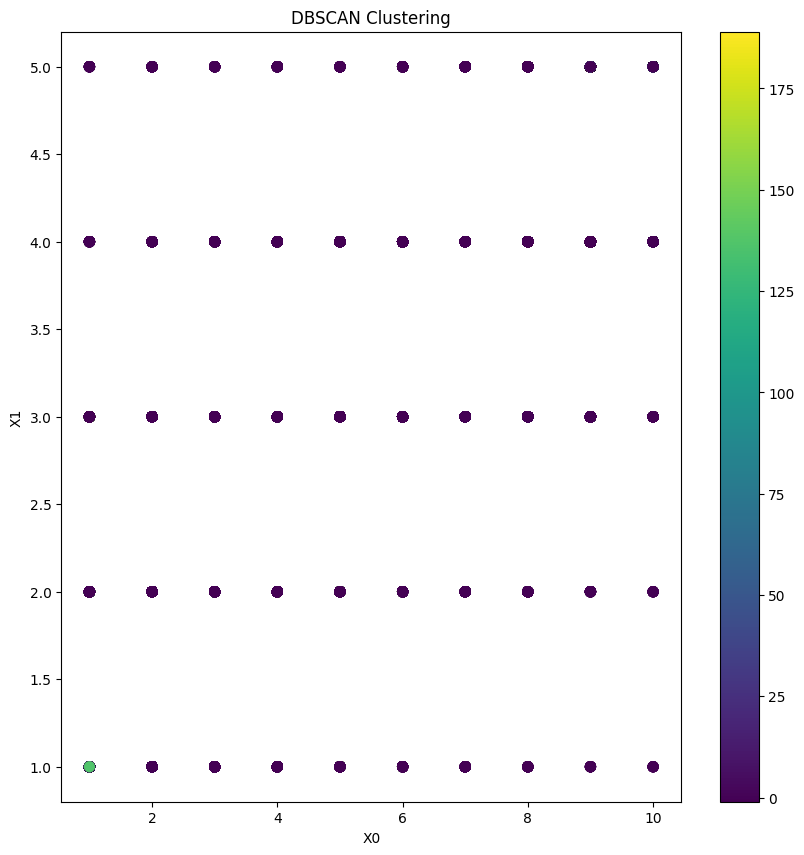

In [ ]:
fig = plt.figure(figsize=(10,10)); ax = fig.add_subplot(111)
scatter = ax.scatter(y['overall'],y['ground_service'], c=y["Cluster"],s=50)
ax.scatter(y['overall'],y['ground_service'], c=y["Cluster"],s=50)
ax.set_title("DBSCAN Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,entertainment,ground_service,kmeans,value_for_money,recommended,Verified,Start,Transit,Destination,aircraft_manu
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,5.0,5.0,1,5.0,yes,True,Washington Dulles,False,Karachi,Airbus
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,3.0,1.0,0,2.0,no,True,Basel,True,Istanbul,Both
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,3.0,3.0,0,3.0,yes,False,Abu Dhabi,True,Istanbul,Both
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,1.0,1.0,0,1.0,no,True,Venice,True,Istanbul,Airbus
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,2.0,1.0,0,1.0,no,True,Houston,True,Istanbul,Boeing


In [ ]:
!apt install proj-bin libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.9.1-1~focal0).
libproj-dev is already the newest version (7.2.1-1~focal0).
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 170 kB of archives.
After this operation, 485 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal/main amd64 proj-bin amd64 7.2.1-1~focal0 [170 kB]
Fetched 170 kB in 0s (345 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 122542 files and directories currently installed.)
Preparing to unpack .../proj-bin_7.2.1-1~focal0_amd64.deb ...
Unpacking proj-bin (7.2.1-1~focal0) ...
Setting up proj-bin (7.2.1-1~focal0) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 132.4 MB 16.2 MB/s 0:00:15
  Preparing metadata (setup.py) ... done
  Using cached pyproj-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.7 MB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for basemap
  Running setup.py clean for basemap
Failed to build basemap
ERROR: Could not build wheels for basemap, which is required to install pyproject.toml-based projects


In [ ]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 340 kB of archives.
After this operation, 1,538 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex6 amd64 1.9.3-1build1 [266 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-c6 amd64 1.9.3-1build1 [58.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-dev amd64 1.9.3-1build1 [16.0 kB]
Fetched 340 kB in 0s (1,368 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 122567 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-

<ipython-input-3-a062862c0fe0>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

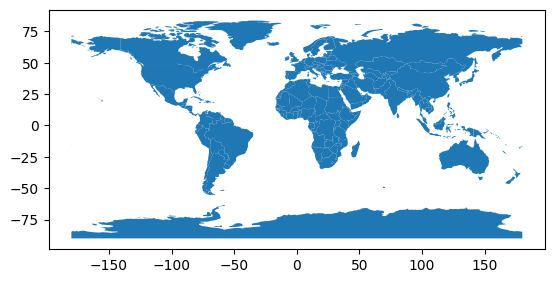

In [ ]:
import geopandas as gpd
import pandas as pd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

### **Reviews Analysis**




In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,ground_service,value_for_money,recommended,Verified,Start,Transit,Destination,aircraft_manu,month,Season
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,5.0,5.0,yes,True,Washington Dulles,False,Karachi,Airbus,4,Spring
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,1.0,2.0,no,True,Basel,True,Istanbul,Both,4,Spring
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,3.0,3.0,yes,False,Abu Dhabi,True,Istanbul,Both,4,Spring
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,1.0,1.0,no,True,Venice,True,Istanbul,Airbus,2,Winter
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,1.0,1.0,no,True,Houston,True,Istanbul,Boeing,3,Spring


In [ ]:
x = airline['customer_review']

recommendation_mapping = {
           'yes': 1,
           'no': 0}

y = airline["recommended"].map(recommendation_mapping)

#y = pd.get_dummies(airline["recommended"])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.20)

In [ ]:
X_train[0]

' Flew on Turkish Airlines IAD-IST-KHI and return KHI-IST-IAD. Turkish Airlines has consistently maintained its quality since I first flew with them in 2007. The flights leave on time, the catering is excellent, the inflight entertainment is extensive and the interface easy to use, and the cabin crew is excellent. Interesting though the A330 on the KHI-IST route and return seemed to have more leg room and was newer than the A330 on the IAD-IST route which was showing its age. The A330 on the IAD-IST route had a slow responding interface for the inflight entertainment and a broken table on the return flight. But Turkish Airlines will be replacing the A330 on its flight to IAD with the 787 sometime in the summer. Turkish food was served on the return leg which I personally like, and I saw the cabin staff helping elderly passengers walk to the lavatory which was nice. Overall another wonderful experience with Turkish Airlines.'

In [ ]:
Y_train[0]

1

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 1000, lower = True)
tokenizer.fit_on_texts(X_train)

#Convert words into a sequence of numbers in the training set
X_train = tokenizer.texts_to_sequences(X_train)
#Convert words into a sequence of numbers in the testing set
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(X_train[0])

[1, 240, 13, 5, 78, 11, 5, 76, 310, 79, 6, 594, 3, 102, 496, 63, 658, 43, 6, 95, 470, 316, 122, 69, 240, 6, 4, 43, 546, 3, 313, 19, 25, 31, 252, 1, 140, 807, 12, 616, 487, 9, 24, 69, 78, 6, 491, 24, 32, 103, 7, 17, 16, 13, 225, 712, 2, 60, 380, 3, 87, 51, 5, 961, 69, 73, 2, 712, 140, 32, 16, 393, 26, 198, 21, 14, 174, 7, 43, 19, 316, 122, 126, 74, 1, 1, 426, 362, 4, 5, 184, 1, 27, 4, 424, 17, 15, 822, 1, 30, 4, 29, 2, 1, 279, 166, 105, 169, 35, 7, 658, 14, 283, 346, 17, 7, 115, 14, 231]


In [ ]:
from keras.utils import pad_sequences

maxlen = 200
X_train = pad_sequences(X_train,padding = 'post',maxlen= maxlen)
X_test = pad_sequences(X_test,padding = 'post',maxlen= maxlen)

In [ ]:
from keras.utils import to_categorical
num_classes = 2
y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

In [ ]:
X_train[0]

array([  1, 240,  13,   5,  78,  11,   5,  76, 310,  79,   6, 594,   3,
       102, 496,  63, 658,  43,   6,  95, 470, 316, 122,  69, 240,   6,
         4,  43, 546,   3, 313,  19,  25,  31, 252,   1, 140, 807,  12,
       616, 487,   9,  24,  69,  78,   6, 491,  24,  32, 103,   7,  17,
        16,  13, 225, 712,   2,  60, 380,   3,  87,  51,   5, 961,  69,
        73,   2, 712, 140,  32,  16, 393,  26, 198,  21,  14, 174,   7,
        43,  19, 316, 122, 126,  74,   1,   1, 426, 362,   4,   5, 184,
         1,  27,   4, 424,  17,  15, 822,   1,  30,   4,  29,   2,   1,
       279, 166, 105, 169,  35,   7, 658,  14, 283, 346,  17,   7, 115,
        14, 231,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN
from keras import optimizers
from keras.utils import pad_sequences
import numpy as np

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)


(11369, 200, 1)
(2843, 200, 1)


In [ ]:
num_classes = 2

def vanilla_rnn():
  model = Sequential()
  model.add(SimpleRNN(50,input_shape=(maxlen,1),return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('Softmax'))
  model.summary()

  adam = optimizers.Adam(learning_rate=0.0001)
  model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
  return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn= vanilla_rnn,epochs = 20, batch_size=50)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
 activation_6 (Activation)   (None, 2)                 0         
                                                                 
Total params: 2,702
Trainable params: 2,702
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-74-6944a837b9aa>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= vanilla_rnn,epochs = 20, batch_size=50)


228/228 [==============================] - 32s 138ms/step - loss: 0.7036 - accuracy: 0.6291 - val_loss: 0.6283 - val_accuracy: 0.6673
Epoch 2/20
228/228 [==============================] - 30s 131ms/step - loss: 0.6728 - accuracy: 0.6612 - val_loss: 0.6227 - val_accuracy: 0.6687
Epoch 3/20
228/228 [==============================] - 30s 132ms/step - loss: 0.6733 - accuracy: 0.6623 - val_loss: 0.6188 - val_accuracy: 0.6725
Epoch 4/20
228/228 [==============================] - 30s 132ms/step - loss: 0.6650 - accuracy: 0.6627 - val_loss: 0.6197 - val_accuracy: 0.6722
Epoch 5/20
228/228 [==============================] - 30s 131ms/step - loss: 0.6615 - accuracy: 0.6651 - val_loss: 0.6194 - val_accuracy: 0.6673
Epoch 6/20
228/228 [==============================] - 31s 136ms/step - loss: 0.6610 - accuracy: 0.6648 - val_loss: 0.6190 - val_accuracy: 0.6673
Epoch 7/20
228/228 [==============================] - 30s 131ms/step - loss: 0.6596 - accuracy: 0.6638 - val_loss: 0.6200 - val_accuracy: 0.6

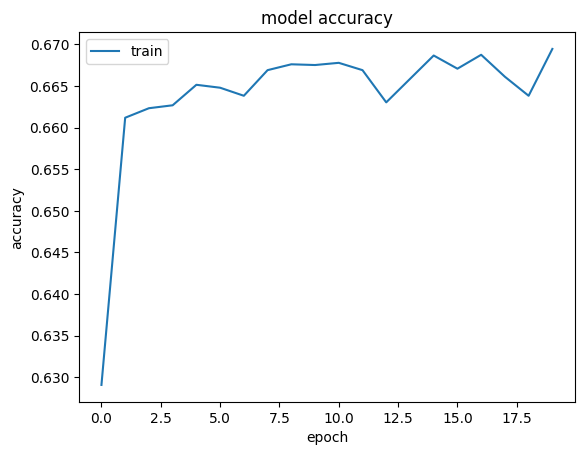

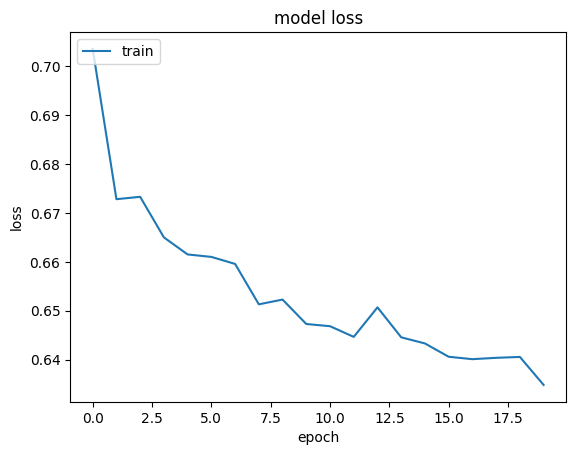

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Word Bubble

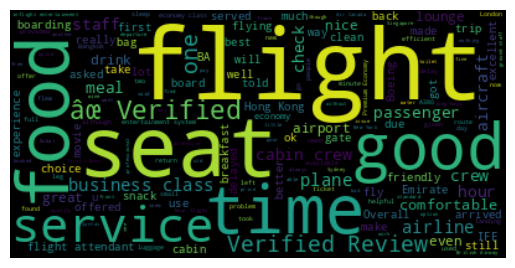

In [ ]:
common_words=''
for i in airline.customer_review:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from keras.utils import pad_sequences
lb=LabelEncoder()
airline['recommended'] = lb.fit_transform(airline['recommended'])
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(airline['customer_review'].values)
X = tokenizer.texts_to_sequences(airline['customer_review'].values)
X = pad_sequences(X)

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 524, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 524, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Splitting the data into training and testing
y=pd.get_dummies(airline['recommended'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
batch_size=32
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
311/311 [==============================] - 537s 2s/step - loss: 0.4469 - accuracy: 0.7876 - val_loss: 0.3338 - val_accuracy: 0.8614
Epoch 2/5
311/311 [==============================] - 515s 2s/step - loss: 0.3438 - accuracy: 0.8537 - val_loss: 0.3319 - val_accuracy: 0.8600
Epoch 3/5
311/311 [==============================] - 515s 2s/step - loss: 0.3124 - accuracy: 0.8718 - val_loss: 0.3191 - val_accuracy: 0.8738
Epoch 4/5
311/311 [==============================] - 513s 2s/step - loss: 0.2904 - accuracy: 0.8801 - val_loss: 0.3117 - val_accuracy: 0.8743
Epoch 5/5
311/311 [==============================] - 510s 2s/step - loss: 0.2827 - accuracy: 0.8819 - val_loss: 0.3120 - val_accuracy: 0.8727


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


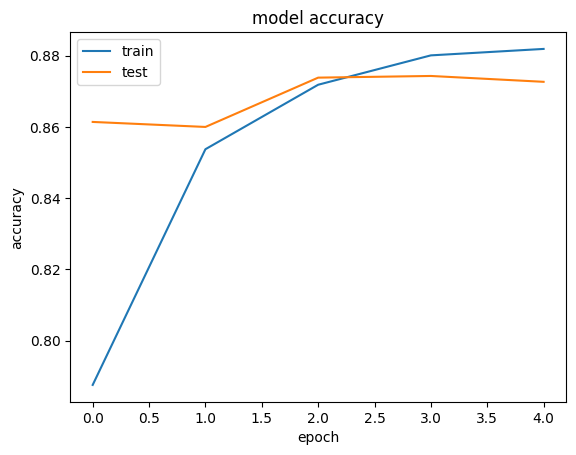

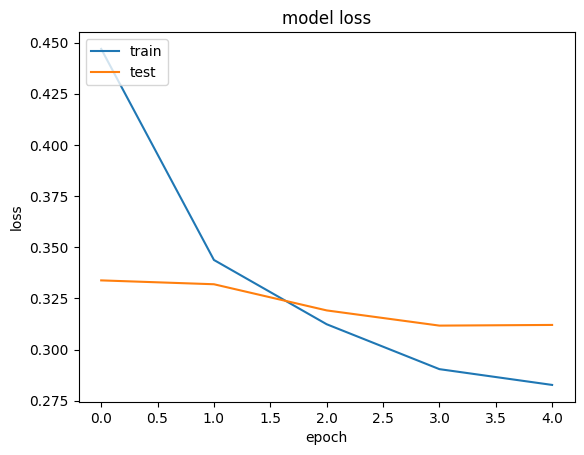

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

134/134 [==============================] - 20s 147ms/step - loss: 0.3264 - accuracy: 0.8616


[0.3263968527317047, 0.8616322875022888]

In [ ]:
sample_review = tokenizer.texts_to_sequences('the flight was comfortable, i had a good time')

sample_review = pad_sequences(sample_review)
pred  = model.predict(sample_review)


2/2 [==============================] - 0s 5ms/step


In [ ]:
print(pred)

[[0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.4721164  0.5278836 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.5052154  0.49478456]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.5052154  0.49478456]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.4721164  0.5278836 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.5052154  0.49478456]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.5052154  0.49478456]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
 [0.47449908 0.5255009 ]
